## Introduction to Boto3 and AWS Serverless Solutions

Let's say that we wanted to detect objects in an image, extract text from images, or perform sentiment analysis on a text. We could write and train our own classifiers, run our classifier on a server (e.g. an EC2 instance) and use this to make predictions. This requires a lot of time and energy in selecting the appropriate hardware, software, techniques, etc. necessary to perform these operations.

For this reason, all the major cloud providers offer serverless "functions as a service" which are pre-trained/coded models that you simply need to provide data to and you will receive a response. Your cloud provider (e.g. AWS) will spin up the compute instances necessary to actually run the code. 

You can access all of these through the AWS Console, but it is easier to integrate them into your existing code via the Boto3 SDK.

In [1]:
import boto3
import json
import time
import requests
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

For instance, we can interact with AWS' image recognition functions like so:

In [7]:
rekog = boto3.client('rekognition')

In [8]:
# detect the objects in the provided image
with open('uchicago.jpg', 'rb') as image:
    response = rekog.detect_labels(Image={'Bytes': image.read()})
    
[(label['Name'], label['Confidence']) for label in response['Labels']][:5]

[('Architecture', 99.19303131103516),
 ('Building', 99.19303131103516),
 ('Campus', 99.19303131103516),
 ('Person', 97.88841247558594),
 ('City', 97.48779296875)]

In [9]:
print(response)

{'Labels': [{'Name': 'Architecture', 'Confidence': 99.19303131103516, 'Instances': [], 'Parents': [], 'Aliases': [], 'Categories': [{'Name': 'Buildings and Architecture'}]}, {'Name': 'Building', 'Confidence': 99.19303131103516, 'Instances': [], 'Parents': [{'Name': 'Architecture'}], 'Aliases': [], 'Categories': [{'Name': 'Buildings and Architecture'}]}, {'Name': 'Campus', 'Confidence': 99.19303131103516, 'Instances': [], 'Parents': [{'Name': 'Architecture'}, {'Name': 'Building'}], 'Aliases': [], 'Categories': [{'Name': 'Buildings and Architecture'}]}, {'Name': 'Person', 'Confidence': 97.88841247558594, 'Instances': [{'BoundingBox': {'Width': 0.06593916565179825, 'Height': 0.2719631493091583, 'Left': 0.9137342572212219, 'Top': 0.726934015750885}, 'Confidence': 97.88841247558594}, {'BoundingBox': {'Width': 0.04518787935376167, 'Height': 0.18150395154953003, 'Left': 0.4945463240146637, 'Top': 0.75595623254776}, 'Confidence': 96.16867065429688}, {'BoundingBox': {'Width': 0.0400175042450428

In [10]:
# Can also count number of instances of each label: e.g. "Person" - label 3
len(response['Labels'][3]['Instances'])

15

We can use rekognition to detect text in images as well:

In [11]:
with open('uchicago_sign.jpg', 'rb') as image:
    response = rekog.detect_text(Image={'Bytes': image.read()})

In [12]:
for text in response['TextDetections']:
    if text['Type'] == 'LINE' and text['Confidence'] > 90:
        print ('Detected text:' + text['DetectedText'])
        print ('Confidence: ' + "{:.2f}".format(text['Confidence']) + "%")

Detected text:THE UNIVERSITY OF
Confidence: 99.61%
Detected text:CHICAGO
Confidence: 99.58%


If you have custom workflows, Rekognition might not be the best option, but for many general applications, this will likely handle everything that you need to do and is really easy to use.

You will have a chance to practice using more of these serverless tools in the DataCamp course that we've assigned as one of the readings for Monday's class, but this should give you a taste of some of the functionality that is available to you right out of the box.

----

**AWS Lambda Functions**

We can also create our own custom serverless functions as well, though, via AWS Lambda... 

*Go to AWS Console and create/deploy sample Lambda function (called `hello_world`) using LabRole IAM role:*

```python
def lambda_handler(event, context):
    # test: {'key1': 1, 'key2': 2}
    total = event['key1'] + event['key2']
    return total
```

Can write code of arbitrary complexity in here, assuming it's going to be a relatively quick operation (e.g. less than 300s)...

In [15]:
aws_lambda = boto3.client('lambda')

test_data = {'key1': 1, 'key2': 2}

# run synchronously:
r = aws_lambda.invoke(FunctionName='hello_world',
                      InvocationType='RequestResponse',
                      Payload=json.dumps(test_data))
json.loads(r['Payload'].read()) # print out response

3

Currently still running all of this code serially, though. Real advantage of
Lambda is that it scales automatically to meet concurrent demand, meaning
that it will automatically parallelize based on how many concurrent invocations
it receives (***just don't invoke your Lambda functions more than 10 times concurrently using your AWS Academy account or your account could be deactivated***; in a personal account, these can scale to 1000s of concurrent invocations, though):

In [16]:
# 1. write function to invoke our function for us and pass in data:
def invoke_function(data):
    r = aws_lambda.invoke(FunctionName='hello_world',
                       InvocationType='RequestResponse',
                       Payload=json.dumps(data))
    return json.loads(r['Payload'].read())

# 2. Demo that lambda function will scale out if called concurrently on different threads locally
with ThreadPoolExecutor(max_workers=4) as executor:
    results = executor.map(invoke_function, [test_data for _ in range(4)])

# 3. In AWS Console: confirm that we had four concurrent executions (takes a few seconds to update)
# Same results too:
[result for result in results]

[3, 3, 3, 3]

Ideally, we should be able to scale out to as many available Lambda workers as possible (i.e. thousands of concurrent function invocations on different segments of a dataset -- a serverless domain decomposition) and not be limited by our local resources, though. 

This is a where AWS [Step Functions](https://docs.aws.amazon.com/step-functions/latest/dg/welcome.html) can be very useful -- orchestrating large, embarrassingly parallel code execution across many Lambda workers with very little code (all we need to do is specify a graphical model for how our Lambda Function should be invoked!). Specifically, we'll be using the ["map" state](https://docs.aws.amazon.com/step-functions/latest/dg/tutorial-creating-map-state-machine.html) to scatter input data to multiple Lambda workers at the same time and selecting the [express workflow Step Function option](https://docs.aws.amazon.com/step-functions/latest/dg/concepts-standard-vs-express.html) to a run our short job synchronously.

(Demonstrate how to incorporate Lambda Function into Step Function workflow via graphical model in console after launching state machine via programmatic approach below).

In [21]:
sfn = boto3.client('stepfunctions')
iam_client = boto3.client('iam')
role = iam_client.get_role(RoleName='LabRole')

def make_def(lambda_arn):
    definition = {
      "Comment": "My State Machine",
      "StartAt": "Map",
      "States": {
        "Map": {
          "Type": "Map",
          "End": True,
          "MaxConcurrency": 10,
          "Iterator": {
            "StartAt": "Lambda Invoke",
            "States": {
              "Lambda Invoke": {
                "Type": "Task",
                "Resource": "arn:aws:states:::lambda:invoke",
                "OutputPath": "$.Payload",
                "Parameters": {
                  "Payload.$": "$",
                  "FunctionName": lambda_arn
                },
                "Retry": [
                  {
                    "ErrorEquals": [
                      "Lambda.ServiceException",
                      "Lambda.AWSLambdaException",
                      "Lambda.SdkClientException",
                      "Lambda.TooManyRequestsException",
                      "States.TaskFailed",
                      "Lambda.Unknown"
                    ],
                    "IntervalSeconds": 2,
                    "MaxAttempts": 6,
                    "BackoffRate": 2
                  }
                ],
                "End": True
              }
            }
          }
        }
      }
    }
    return definition

# plug in unique ARN identifier for function
lambda_arn = aws_lambda.get_function(FunctionName='hello_world')['Configuration']['FunctionArn']
sf_def = make_def(lambda_arn)

try:
    response = sfn.create_state_machine(
        name='hello_world_sm',
        definition=json.dumps(sf_def),
        roleArn=role['Role']['Arn'],
        type='EXPRESS'
    )
except sfn.exceptions.StateMachineAlreadyExists:
    response = sfn.list_state_machines()
    state_machine_arn = [sm['stateMachineArn'] 
                         for sm in response['stateMachines'] 
                         if sm['name'] == 'hello_world_sm'][0]
    response = sfn.update_state_machine(
        stateMachineArn=state_machine_arn,
        definition=json.dumps(sf_def),
        roleArn=role['Role']['Arn']
    )

response = sfn.list_state_machines()
print(response)

{'stateMachines': [{'stateMachineArn': 'arn:aws:states:us-east-1:654654411374:stateMachine:hello_world_sm', 'name': 'hello_world_sm', 'type': 'EXPRESS', 'creationDate': datetime.datetime(2025, 4, 23, 14, 53, 26, 623000, tzinfo=tzlocal())}, {'stateMachineArn': 'arn:aws:states:us-east-1:654654411374:stateMachine:word_count_sm', 'name': 'word_count_sm', 'type': 'EXPRESS', 'creationDate': datetime.datetime(2025, 4, 18, 14, 25, 48, 340000, tzinfo=tzlocal())}], 'ResponseMetadata': {'RequestId': '2fded9b5-927d-4cbc-8eaf-9871168f8241', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2fded9b5-927d-4cbc-8eaf-9871168f8241', 'date': 'Wed, 23 Apr 2025 19:53:26 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '338', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [22]:
# Get arn for Step Function state machine
state_machine_arn = [sm['stateMachineArn'] 
                     for sm in response['stateMachines'] 
                     if sm['name'] == 'hello_world_sm'][0]

# generate test data to pass as input
# "Map" will automatically invoke a separate Lambda function
# to process each dictionary in the list (5 concurrently)
data = [{"key1": 1, "key2": 2} for _ in range(5)]

Once we have the identifier (ARN) for our Step Function state machine, we can pass in input data in JSON format. We have two options for execution -- synchronous execution (e.g. our notebook will wait for a response from AWS before moving on to the next cell), and asynchronous execution (which we might want to use if our Lambda functions were writing results to a cloud database and we don't need to wait for execution to finish before moving on with our code).

In [11]:
# Synchronous Execution
response = sfn.start_sync_execution(
    stateMachineArn=state_machine_arn,
    name='sync_test',
    input=json.dumps(data)
)

print(response['output'])

[3,3,3,3,3]


In [12]:
# Async; perhaps writing results to db and don't need to wait for execution to finish before moving on with code
response = sfn.start_execution(
    stateMachineArn=state_machine_arn,
    name='async_test',
    input=json.dumps(data)
)

print(response) # no results returned for async option
# Can go into logs in Cloud Watch and see execution results (Express SF workflow)
# Note that Standard Step Function workflow allows us to audit results via Boto3)

{'executionArn': 'arn:aws:states:us-east-1:991793028403:express:hello_world_sm:async_test:3a33f5b9-4d68-47d1-9e5d-6220bddb5fb8', 'startDate': datetime.datetime(2025, 4, 14, 11, 4, 50, 522000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '4e5b7a1a-9c52-4fe9-a0d4-bffca7de702a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4e5b7a1a-9c52-4fe9-a0d4-bffca7de702a', 'date': 'Mon, 14 Apr 2025 16:04:50 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '156', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


## Using AWS Lambda to make HTTP Requests in Parallel

A common task for computational social scientists is making HTTP requests to access and process web data. It can be quite limiting to make these requests serially, though. When we do, the amount of data we are able to collect is limited both by our internet bandwidth and machine's ability to sequentially process the data.

It would be much better to parallelize this workflow. Here, we'll take a look at how we could do this in a serverless fashion using the same workflow as above (Mapping Data to Lambda Functions via Step Functions). Specifically, we will call the [Google Books API](https://developers.google.com/books/docs/v1/getting_started) in parallel on a list of ISBNs (one API call can be constructed [like this](https://www.googleapis.com/books/v1/volumes?q=isbn:1906523371)), calculating the number of words used in the description for each book in our ISBN list (see workflow below). Word count is a simple metric (used here as a proof-of-concept), but it would also be possible to perform other Natural Language Processing routines using this same approach. Such a cloud workflow allows us to gather and process far greater amounts of data than would be otherwise possible on our local machines.

![AWS Serverless Workflow](serverless_workflow.png)

First, we'll need to load in a list of ISBNs (provided in this directory):

In [2]:
with open('isbn.txt') as file:
    isbn_list = [isbn.strip() for isbn in file]

Then, we can write a function that will take in a list of ISBNs and compute the the number of words in the description of the corresponding book:

In [3]:
def get_desc_wc(isbn_list):
    '''
    Takes in a list of ISBNs and returns a list of description
    word counts corresponding to each ISBN (via the Google
    Books API).
    '''
    url = "https://www.googleapis.com/books/v1/volumes?q=isbn:"
    wc_list = []
    for isbn in isbn_list:
        r = requests.get(url + isbn)
        data = r.json()
        # Try to get description, but if there is none, set
        # word count to be 0 for that book
        try:
            description = data['items'][0]['volumeInfo']['description']
            wc_list.append(len(description.split()))
        except KeyError:
            wc_list.append(0)
    return wc_list

We can then call our function and it will sequentially request information and calculate the description word count for each one of our ISBNs in the list:

Time elapsed (in seconds) - Serial:  218.12692379951477


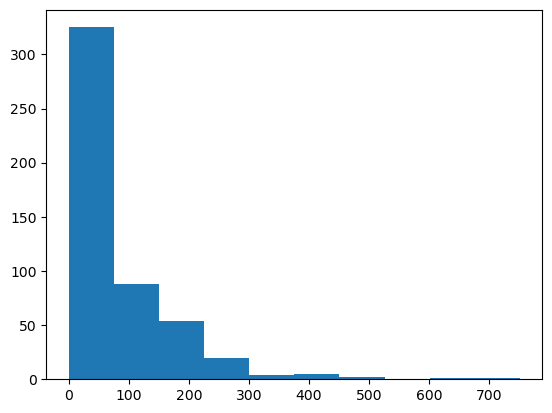

In [4]:
start = time.time()
wc_list = get_desc_wc(isbn_list)
time_elapsed = time.time() - start

print("Time elapsed (in seconds) - Serial: ", time_elapsed)

plt.hist(wc_list);

This is a bit slow (exactly how slow will be variable and heavily based on your internet connection!), though, and could benefit from parallelization. One way we can do this in a "serverless" fashion is by using AWS Step Functions to invoke many AWS Lambda functions to make these ISBN API calls (and calculate the description word count) in parallel. 

In a personal AWS account, you can make up to [3000 concurrent Lambda invocations in an initial burst, scaling by an additional 500 instances each minute that your code runs (until your account's concurrency limit is reached)](https://docs.aws.amazon.com/lambda/latest/dg/invocation-scaling.html). Note, though, that we're limited in our AWS Academy accounts to making up to 10 concurrent Lambda invocations. As a result, we won't be able to see the same scalability as we would see in a personal account (it'll be up to ~60x slower!), but you can at least get the idea of how this pipeline can be constructed.

To make this work, we'll do the same thing we did above in our "Hello World" case -- using Step Functions to invoke multiple Lambda functions in parallel and then return the output of the executions synchronously to our local machine. 

For our Lambda function, we can write a `lambda_handler` that uses our API request function above like so (to be run on mini-batches of the overall isbn list):

```python
import requests

def get_desc_wc(isbn_list):
    '''
    Takes in a list of ISBNs and returns a list of description
    word counts corresponding to each ISBN (via the Google
    Books API).
    '''
    url = "https://www.googleapis.com/books/v1/volumes?q=isbn:"

    wc_list = []
    for isbn in isbn_list:
        r = requests.get(url + isbn)
        data = r.json()
        # Try to get description, but if there is none, set
        # word count to be 0 for that book
        try:
            description = data['items'][0]['volumeInfo']['description']
            wc_list.append(len(description.split()))
        except KeyError:
            wc_list.append(0)
    return wc_list

def lambda_handler(event, context):
    wc = get_desc_wc(event['isbn'])
    return wc
```

The only tricky thing with running this particular code as a Lambda function is that we are importing in the `requests` module in order to make HTTP requests. Such dependencies are not included by default in Lambda's Python runtimes.

In order to work with dependencies, we'll need to package our Lambda Function with all of its dependencies (which you can do manually [like so](https://docs.aws.amazon.com/lambda/latest/dg/python-package.html#python-package-create-package-with-dependency) or by adding a [predefined "layer" defined by a 3rd-party](https://api.klayers.cloud//api/v2/p3.9/layers/latest/us-east-1/html) via its ARN in the Lambda dashboard).  Note as well that [you also can work with Docker container images](https://docs.aws.amazon.com/lambda/latest/dg/python-image.html) (AWS provides up-to-date base images for Lambda) to test and upload your function to AWS. The Docker approach is not necessary for any of the assignments/exam in the class, but you may need to explore this option if you use this approach in your own research (i.e. if you're working with an especially big model, or large software not already installed on Lambda, our normal Lambda function creation workflow will not work). 

Using the manual workflow linked above, we have included a zipped version of the Lambda function (with its dependencies) in this directory (`word_count.zip`) that you can upload and use (**walk through directory structure live in class**). You'll need to do the same if you want to provide added functionality to your Lambda functions (e.g. `BeautifulSoup` for web-scraping, `numpy` or `pandas` for analytical workflows, etc.). We'll also need to increase our lambda timeout so that we have enough time for our program to run to perform longer running jobs (the default is a 3s timeout).

Let's use `boto3` this time to create our Lambda Function from our zipped `word_count.zip` (to demonstrate that we can do this programmatically as well as in the console as we did earlier):

In [17]:
# Access our class IAM role, which allows Lambda
# to interact with other AWS resources
iam_client = boto3.client('iam')
role = iam_client.get_role(RoleName='LabRole')

# Open our Zipped directory
with open('word_count.zip', 'rb') as f:
    lambda_zip = f.read()

try:
    # If function hasn't yet been created, create it
    response = aws_lambda.create_function(
        FunctionName='word_count',
        Runtime='python3.9',
        Role=role['Role']['Arn'],
        Handler='lambda_function.lambda_handler',
        Code=dict(ZipFile=lambda_zip),
        Timeout=300
    )
except aws_lambda.exceptions.ResourceConflictException:
    # If function already exists, update it based on zip
    # file contents
    response = aws_lambda.update_function_code(
        FunctionName='word_count',
        ZipFile=lambda_zip
    )

# Throttle concurrent executions to 10
response = aws_lambda.put_function_concurrency(
        FunctionName='word_count',
        ReservedConcurrentExecutions=10
    )

Once we have our function, we can incorporate it into a Step Function state machine, like we did in our Hello World example and provide data that will be spread across our Lambda worker invocations. Remember, we can only perform 10 concurrent invocations in AWS Academy, so we need to subdivide our list of ISBNs into a small number of equal batches. Let's split our job into 5 batches to be safely under the concurrency limit:

In [18]:
n = 500 // 5 # subdivide list of ISBNs into 5 equal batches
isbn_batches = [{'isbn': isbn_list[i:i + n]} for i in range(0, len(isbn_list), n)]

In [19]:
# 5 lists of 100 ISBNs
print(len(isbn_batches), len(isbn_batches[0]['isbn']))

5 100


In [23]:
lambda_arn = aws_lambda.get_function(FunctionName='word_count')['Configuration']['FunctionArn']
sf_def = make_def(lambda_arn)

try:
    response = sfn.create_state_machine(
        name='word_count_sm',
        definition=json.dumps(sf_def),
        roleArn=role['Role']['Arn'],
        type='EXPRESS'
    )
except sfn.exceptions.StateMachineAlreadyExists:
    response = sfn.list_state_machines()
    state_machine_arn = [sm['stateMachineArn'] 
                         for sm in response['stateMachines'] 
                         if sm['name'] == 'word_count_sm'][0]
    response = sfn.update_state_machine(
        stateMachineArn=state_machine_arn,
        definition=json.dumps(sf_def),
        roleArn=role['Role']['Arn']
    )

# Get arn for Step Function state machine
response = sfn.list_state_machines()
state_machine_arn = [sm['stateMachineArn'] 
                     for sm in response['stateMachines'] 
                     if sm['name'] == 'word_count_sm'][0]

In [24]:
# Spread ISBN batches across Lambda workers
start = time.time()
response = sfn.start_sync_execution(
    stateMachineArn=state_machine_arn,
    name='isbn_500',
    input=json.dumps(isbn_batches)
)
time_elapsed = time.time() - start

In [20]:
print(time_elapsed)

37.294769287109375


Using only 5 Lambda workers, this is ~3-5x faster than the serial solution (meaning we can gather more data in the same amount of time, re: Gustafson's Law!). If we ran this same code on larger sets of ISBNs in a personal account, we would expect our compute time to remain similar, so long as we stay beneath the 3000 concurrent Lambda invocation maximum. You can also see that our parallel solution produces a similar distribution of word counts as the serial solution (with slight differences as a result of our permissive try/except logic):

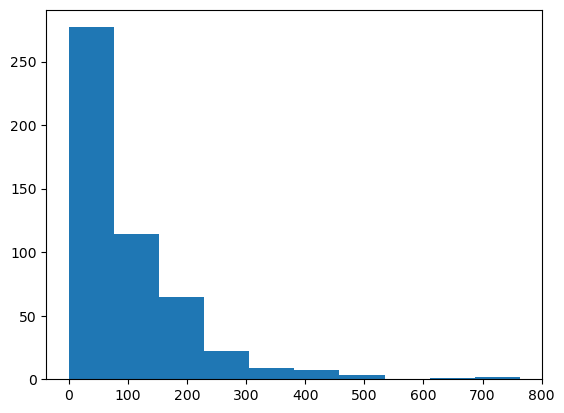

In [24]:
output = json.loads(response['output'])
plt.hist([num for sublist in output for num in sublist]);

So, we can quickly parallelize workflows in a serverless fashion using a combination of AWS Lambda and Step Functions. You can also create even more complicated workflows in Step Functions involving functional decomposition, multiple layers of Lambda function invocations, and more.

One thing to note with the workflow above is that the payload size for inputs and outputs is not infinite (Step Functions will only accept inputs and outputs of size [262 KB or less](https://docs.aws.amazon.com/step-functions/latest/dg/avoid-exec-failures.html)). So, if you are working with really big inputs and/or outputs, you will want to input data from AWS cloud databases/distributed storage systems (e.g. providing the keys to the data you're referencing in the input JSON) and output data to a database/storage system within your Lambda function invocation as well. You can see an example of this workflow in the [replication materials for Clindaniel and Magnani 2024](https://github.com/jonclindaniel/digital-formation-processes) in the context of a high-frequency data collection task.

We'll talk more about how you can work with cloud databases (which allow you to make many concurrent reads and writes) next week to enable this increased scalability.